# PART 3

In [67]:
import numpy as np
import matplotlib.pyplot as plt

## 1.Questions

### 1.a

In [195]:
class algorithms:
    # we define a single class that runs everything
    def __init__(self, algorithm, max_dims, number_of_training_sets, test_set_size):
        
        # user decides on the algorithm to use in the inputs
        # the other inputs increase run time with larger numbers
        
        if algorithm == "1-nn":
            self.algo = self.one_NN
        elif algorithm == "perceptron":
            self.algo = self.perceptron
        elif algorithm == "winnow":
            self.algo = self.winnow
        elif algorithm == "least squares":
            self.algo = self.least_squares
        else:
            raise NameError("Wrong algorithm string input: please try '1-nn', 'winnow','perceptron','least squares'")
        
        # we initialise all the variables we will need in the class
        self.algo_name = algorithm
        self.max_dims = max_dims
        self.number_of_training_sets = number_of_training_sets
        self.test_set_size= test_set_size
        self.results = np.zeros((max_dims,))
        self.m_per_dim = np.zeros((max_dims, number_of_training_sets))
        self.criterion = 0.1
        self.std_dev = np.zeros((max_dims,))

    def main_loop_method1(self):

        '''
        The main loop where everything is done and called:
        It loops through dimensions, then finds the minimum m
        that satisfies our error criterion for a given number of training sets 
        '''
        m = 0
        # We loop through dimensions
        for n in range(1, self.max_dims):
           
            print("Dimension {} out of {} with number of samples {}".format(n, self.max_dims, m), end="\r")
            # we create a random test set of a give size 
            test = np.random.choice(2, (self.test_set_size, n)) * 2 - 1
            
            # we reset the error
            error = 1
            
            # We use the previous m minus 30% to help with computation time, 
            # this relies on the fact that all the algorithms grow with increasing n
            m=int(m*0.7)
            
            while error >= self.criterion:

                # we increment indices and create an array with the errors for each training set
                m += 1

                error_per_test = np.ones((self.number_of_training_sets,))

                for i in range(self.number_of_training_sets):

                    # We initiate a random seed for consistent plots
                    np.random.seed(i)
                    
                    # we create new training sets
                    training = np.random.choice(2, (m, n)) * 2 - 1

                    # We compute the weights and labels of the test set given an algorithm
                    if self.algo_name == "1-nn":
                        labels = self.one_NN(training, training[:, 0], test)
                    else:
                        weights = self.algo(training, training[:, 0])
                        labels = np.sign(weights @ test.T)

                    # we compute the error and if it is lower than the criterion, we loop again
                    error_per_test[i] = self.generalisation_error(labels, test[:, 0])

                    # We save the number of training examples that were needed for a particular dimension and training set
                    # for this method, the m's for a certain dimension will all be the same.
                    self.m_per_dim[n, i] = m

                error = np.mean(error_per_test)

            # We find the mean of the number of training samples needed for a certain dimension. 
            self.results[n] = np.mean(self.m_per_dim[n, :])
            
            # In this method the list is populated with the same m for a certain dimension
            assert max(self.m_per_dim[n, :]) == min(self.m_per_dim[n, :])

        # We can plot our results: no errorbars :( 
        plt.plot(self.results, ".")
        plt.xlabel("Dimensions of data n")
        plt.ylabel("Number of data points m")
        plt.title("Estimated number of samples to obtain 10% generalisation error with {}".format(self.algo_name))
        plt.show()

        # We return the results as well to be able to inspect them
        return self.results
    
    
    def main_loop_method2(self):
        
        '''
        The main loop where everything is done and called:
        It loops through dimensions, then training sets then finds the minimum m that satisfies our error criterion
        '''
        
        m = 0 
        results_max = np.zeros((self.max_dims,))
        
        # We loop through dimensions
        for n in range(1, self.max_dims):
            
            print("Dimension {} out of {} with number of samples {}".format(n, self.max_dims, m), end="\r")
            
            # we create a test set for a certain dimension
            test = np.random.choice(2, (self.test_set_size, n))*2 -1
            
            for i in range(self.number_of_training_sets):
                
                # We initiate a random seed for consistent plots
                np.random.seed(i)
                
                # using the fact that all the plots grow, we can use the previous minimum m -30%
                m = int(min(self.m_per_dim[n-1,:])*0.7)
                #m=0 
                
                # we reset the error
                error = 1
                
                
                while error >= self.criterion:   
                    
                    # we increment the indices
                    m += 1
                    
                    # we create new training sets
                    training = np.random.choice(2, (m,n))*2 -1
                    
                    # We compute the weights and labels of the test set given an algorithm
                    if self.algo_name == "1-nn":
                        labels = self.one_NN(training, training[:,0], test)
                    else:
                        weights = self.algo(training, training[:,0])
                        labels = np.sign(weights@test.T)
                        
                    # we compute the error and if it is lower than the criterion, we loop again
                    error = self.generalisation_error(labels, test[:,0])
                    
                    # We save the number of training examples that were needed for a particular dimension and training set
                    self.m_per_dim[n, i] = m
                    
                
            # We find the mean and st dev and max of the number of training samples needed for a certain dimension
            self.results[n] = np.mean(self.m_per_dim[n,:])
            results_max[n] = max(self.m_per_dim[n,:])
            self.std_dev[n] = np.std(self.m_per_dim[n,:])
            
        # We can plot our results with errorbars
        plt.errorbar(np.linspace(0,self.max_dims, self.max_dims), self.results, yerr=self.std_dev, fmt=".", label="Average $m$")
        plt.plot(np.linspace(0,self.max_dims, self.max_dims), results_max,".", label="Max $m$")
        plt.xlabel("Dimensions of data n")
        plt.ylabel("Number of data points m")
        plt.legend()
        plt.title("Estimated number of samples to obtain 10% generalisation error with {}".format(self.algo_name))
        plt.show()
        
        # We return the results as well to be able to inspect them
        return self.results
    
    
    def perceptron(self, X, Y):
        '''
        Perceptron algorithm that takes matrix of features X and vecotr of labels Y
        
        '''
        
        # Initialising values
        w = np.zeros((X.shape[1],))
        M = 0
        
        # We loop through the data points
        for i in range(X.shape[0]):
            y_pred = np.sign(np.dot(w, X[i,:]))
            
            # We modify weights if the algorithm got it wrong
            if y_pred*Y[i] <= 0:
                w += Y[i]*X[i,:]
                M += 1
                
            else:
                # We do nothing if it got it right
                pass
            
        return w

    
    def winnow(self, X, Y):
        '''
        Winnow algorithm that takes matrix of features X and vector of labels Y
        
        '''
        
        # Winnow takes inputs of 1s and 0s so we normalise our data
        normalise = lambda x: (x+1)/2

        X = normalise(X)
        Y = normalise(Y)

        n = X.shape[1]
        w = np.ones((X.shape[1],))
        
        # We loop through the datapoints
        for i in range(X.shape[0]):
            
            # We make our prediction
            if np.dot(w, X[i,:]) < n:
                y_pred = 0 
            else: 
                y_pred = 1
            
            # If our prediction is wrong we change our weights vector
            if y_pred != Y[i]:
                w *= 2**((Y[i]-y_pred)*X[i,:])

        return w

    def least_squares(self, X, Y):
        
        '''
        Least squares algorithm that takes matrix of features X and vector of labels Y
        
        '''
        
        # We can use the normal equation with pseudo inverse for stability
        w = np.linalg.pinv(X.T @ X) @ X.T @ Y

        return w 

    def one_NN(self, X, Y, Z):
        
        '''
        1-NN algorithm that takes matrix of features X and vector of labels Y
        
        '''
        normalise = lambda x: (x+1)/2    
        X = normalise(X)
        Y = normalise(Y)
        Z = normalise(Z)
        prediction = np.zeros((Z.shape[0]))

        for i in range(Z.shape[0]):
            distance_matrix = X - Z[i, :]
            norm_vector = np.sum(distance_matrix**2, axis=1)
            closest_point = np.argmin(norm_vector)
            prediction[i] = Y[closest_point]

        return prediction*2 -1

    def generalisation_error(self, pred, labels):
        
        '''
        Generealisation error takes a prediction from our algorithm 
        trained with a specific training set and the true labels and returns the sum of errors 
        
        '''

        return 1/len(labels) * np.sum(pred != labels)

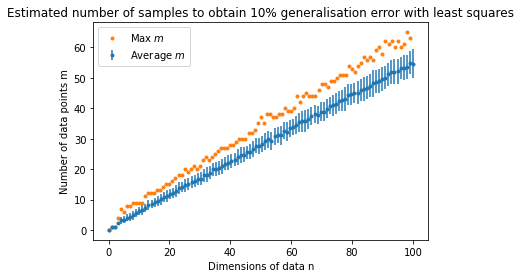

In [187]:
results_leastsq2 = algorithms(algorithm="least squares",max_dims=100, number_of_training_sets=100, test_set_size=200).main_loop_method2()

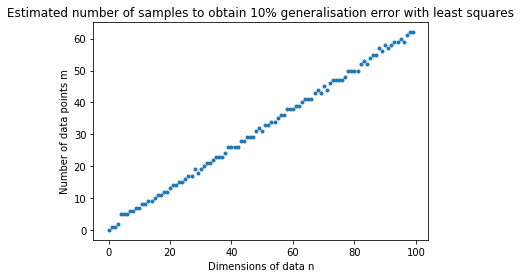

In [188]:
results_leastsq1 = algorithms(algorithm="least squares",max_dims=100, number_of_training_sets=100, test_set_size=200).main_loop_method1()

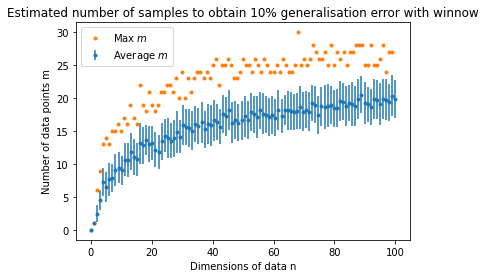

In [189]:
results_winnow2 = algorithms(algorithm="winnow",max_dims=100, number_of_training_sets=100, test_set_size=200).main_loop_method2()

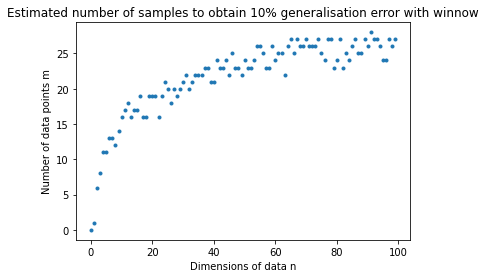

In [190]:
results_winnow1 = algorithms(algorithm="winnow",max_dims=100, number_of_training_sets=100, test_set_size=200).main_loop_method1()

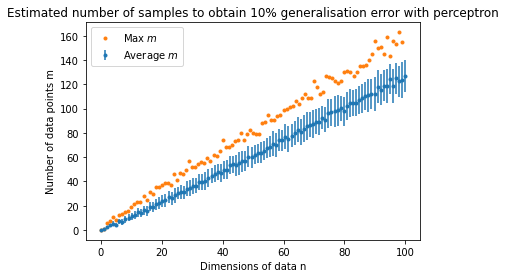

In [191]:
results_perceptron2 = algorithms(algorithm="perceptron",max_dims=100, number_of_training_sets=100, test_set_size=200).main_loop_method2()

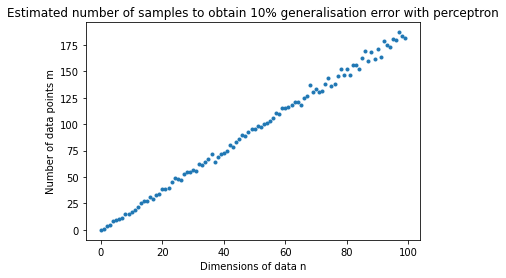

In [192]:
results_perceptron1 = algorithms(algorithm="perceptron",max_dims=100, number_of_training_sets=100, test_set_size=200).main_loop_method1()

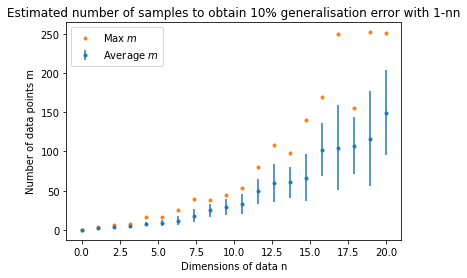

In [201]:
results_1nn2 = algorithms(algorithm="1-nn",max_dims=20, number_of_training_sets=20, test_set_size=50).main_loop_method2()

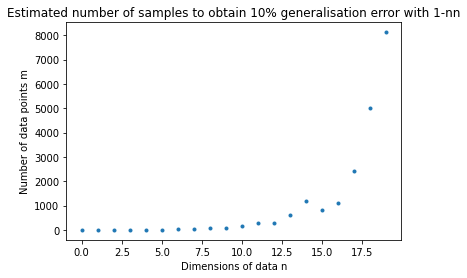

In [53]:
results_1nn1 = algorithms(algorithm="1-nn",max_dims=20, number_of_training_sets=20, test_set_size=50).main_loop_method1()

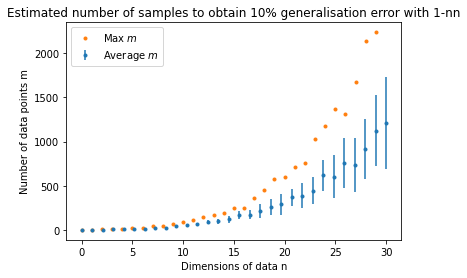

In [185]:
results_1nn1_0m = algorithms(algorithm="1-nn",max_dims=30, number_of_training_sets=30, test_set_size=100).main_loop_method2()

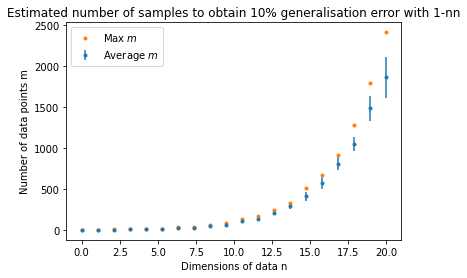

In [200]:
results_1nn1_20dims = algorithms(algorithm="1-nn",max_dims=20, number_of_training_sets=20, test_set_size=1000).main_loop_method2()

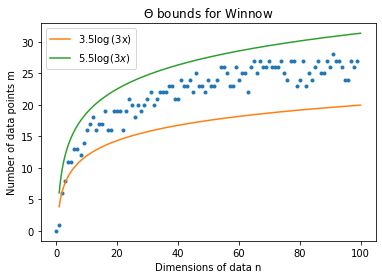

In [128]:
x = np.linspace(1,100,1000)
plt.plot(results_winnow1,".")
plt.plot(x, 3.5*np.log(3*x), label="$3.5\log$(3x)")
plt.plot(x, 5.5*np.log(3*x), label="5.5$\log(3x)$")
plt.title("$\Theta$ bounds for Winnow")
plt.xlabel("Dimensions of data n")
plt.ylabel("Number of data points m")
plt.legend()
plt.show()

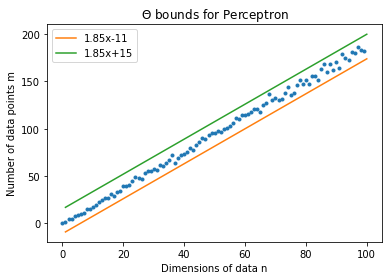

In [129]:
x = np.linspace(1,100,1000)
plt.plot(results_perceptron1,".")
plt.plot(x, 1.85*x-11, label="1.85x-11")
plt.plot(x, 1.85*x+15, label="1.85x+15")
plt.legend()
plt.xlabel("Dimensions of data n")
plt.ylabel("Number of data points m")
plt.title("$\Theta$ bounds for Perceptron")
plt.show()

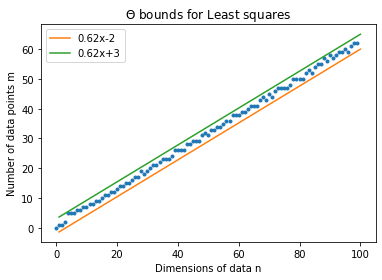

In [130]:
x = np.linspace(1,100,1000)
plt.plot(results_leastsq1,".")
plt.plot(x, 0.62*x-2, label="0.62x-2")
plt.plot(x, 0.62*x+3, label="0.62x+3")
plt.xlabel("Dimensions of data n")
plt.ylabel("Number of data points m")
plt.title("$\Theta$ bounds for Least squares")
plt.legend()
plt.show()

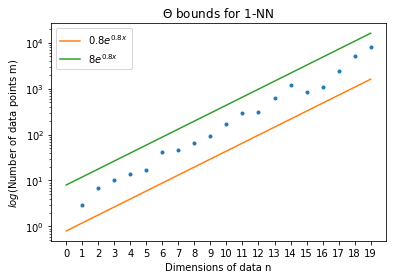

In [202]:
x = np.linspace(0,19,1000)
plt.plot(results_1nn1,".")
plt.plot(x, 0.8*np.exp(0.4*x),label="0.8$e^{0.8x}$")
plt.plot(x, 8*np.exp(0.4*x),label="$8e^{0.8x}$")
plt.xticks([i for i in range(20)])
plt.yscale("log")
plt.title("$\Theta$ bounds for 1-NN")
plt.xlabel("Dimensions of data n")
plt.ylabel("$log$(Number of data points m)")
plt.legend()
plt.show()

C:\Users\theod\AppData\Local\Temp/ipykernel_1300/755416927.py:3: RuntimeWarning: divide by zero encountered in true_divide
  plt.plot(x, 1/x*np.exp(0.5*x),label="0.8$e^{0.8x}$")


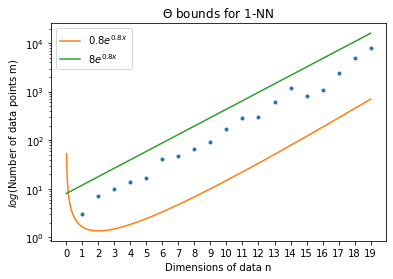

In [211]:
x = np.linspace(0,19,1000)
plt.plot(results_1nn1,".")
plt.plot(x, 1/x*np.exp(0.5*x),label="0.8$e^{0.8x}$")
plt.plot(x, 8*np.exp(0.4*x),label="$8e^{0.8x}$")
plt.xticks([i for i in range(20)])
plt.yscale("log")
plt.title("$\Theta$ bounds for 1-NN")
plt.xlabel("Dimensions of data n")
plt.ylabel("$log$(Number of data points m)")
plt.legend()
plt.show()